In [1]:
# Copyright (c) OpenMMLab. All rights reserved.
import logging
import mimetypes
import os
import time
from argparse import ArgumentParser

import cv2
import json_tricks as json
import mmcv
import mmengine

from mmengine.logging import print_log

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples, split_instances
from mmpose.utils import adapt_mmdet_pipeline

try:
	from mmdet.apis import inference_detector, init_detector
	has_mmdet = True
except (ImportError, ModuleNotFoundError):
	has_mmdet = False


from mmengine.config import Config, ConfigDict
from typing import Union
from mmcv.transforms import Compose
from typing import Optional, Sequence, Union
from mmcv.ops import RoIPool

import numpy as np
import torch
from PIL import Image

from mmpose.apis import inference
from typing import List, Optional, Union

In [2]:
model_config = r'C:\Users\user\Documents\GitHub\mmpose\my_code\work_dirs\HMD_mo2cap2_test\20240807_023443\vis_data\config.py'
model_ckpt = r'C:\Users\user\Documents\GitHub\mmpose\my_code\work_dirs\HMD_mo2cap2_test\epoch_10.pth'
device = 'cuda'

In [3]:
# build pose estimator
pose_estimator = init_pose_estimator(
	model_config,
	model_ckpt,
	device=device,
	# cfg_options=dict(
	# 	model=dict(test_cfg=dict(output_heatmaps=args.draw_heatmap)))
	)
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)

Loads checkpoint by local backend from path: C:\Users\user\Documents\GitHub\mmpose\my_code\work_dirs\HMD_mo2cap2_test\epoch_10.pth


In [4]:
pose_estimator.cfg

Config (path: C:\Users\user\Documents\GitHub\mmpose\my_code\work_dirs\HMD_mo2cap2_test\20240807_023443\vis_data\config.py): {'ann_file_test': 'F:\\mo2cap2_data_half\\TestSet', 'ann_file_train': 'F:\\mo2cap2_data_half\\TrainSet', 'ann_file_val': 'F:\\mo2cap2_data_half\\ValSet', 'auto_scale_lr': {'base_batch_size': 256}, 'backend_args': {'backend': 'local'}, 'codec': {'heatmap_size': (64, 64), 'input_size': (256, 256), 'sigma': 2, 'type': 'Custom_mo2cap2_MSRAHeatmap'}, 'custom_hooks': [{'type': 'SyncBuffersHook'}], 'data_mode': 'topdown', 'dataset_mo2cap2_train': {'data_mode': 'topdown', 'data_root': 'F:\\mo2cap2_data_half\\TrainSet', 'filter_cfg': {'filter_empty_gt': False, 'min_size': 32}, 'pipeline': [{'type': 'LoadImage'}, {'padding': 1.0, 'type': 'GetBBoxCenterScale'}, {'input_size': (256, 256), 'type': 'TopdownAffine'}, {'encoder': {'heatmap_size': (64, 64), 'input_size': (256, 256), 'sigma': 2, 'type': 'Custom_mo2cap2_MSRAHeatmap'}, 'type': 'GenerateTarget'}, {'type': 'PackPoseInp

In [5]:
visualizer.set_dataset_meta(
	pose_estimator.dataset_meta, skeleton_style='mo2cap2')

In [6]:
args = {
	'det_config': 'path/to/det_config',  # detection 설정 파일 경로
	'det_checkpoint': 'path/to/det_checkpoint',  # detection 체크포인트 파일 경로
	'pose_config': 'path/to/pose_config',  # 포즈 설정 파일 경로
	'pose_checkpoint': 'path/to/pose_checkpoint',  # 포즈 체크포인트 파일 경로
	'input': '',  # 이미지/비디오 파일 경로
	'show': False,  # 이미지를 표시할지 여부
	'output_root': '',  # 출력 이미지 파일 루트 경로
	'save_predictions': False,  # 예측 결과를 저장할지 여부
	'device': 'cuda:0',  # 추론에 사용할 장치
	'det_cat_id': 0,  # 바운딩 박스 탐지 모델의 카테고리 ID
	'bbox_thr': 0.3,  # 바운딩 박스 점수 임계값
	'nms_thr': 0.3,  # 바운딩 박스 NMS를 위한 IoU 임계값
	'kpt_thr': 0.3,  # 키포인트 시각화 임계값
	'draw_heatmap': False,  # 모델이 예측한 히트맵을 그릴지 여부
	'show_kpt_idx': False,  # 키포인트의 인덱스를 표시할지 여부
	'skeleton_style': 'mmpose',  # 스켈레톤 스타일 선택
	'radius': 3,  # 시각화할 키포인트 반경
	'thickness': 1,  # 시각화할 링크 두께
	'show_interval': 0,  # 프레임당 대기 시간 (초)
	'alpha': 0.8,  # 바운딩 박스의 투명도
	'draw_bbox': False,  # 인스턴스의 바운딩 박스를 그릴지 여부
	'Visualizer':'CustomPose3dLocalVisualizer',
}

In [7]:


def get_test_pipeline_cfg(cfg: Union[str, ConfigDict]) -> ConfigDict:
    """Get the test dataset pipeline from entire config.

    Args:
        cfg (str or :obj:`ConfigDict`): the entire config. Can be a config
            file or a ``ConfigDict``.

    Returns:
        :obj:`ConfigDict`: the config of test dataset.
    """
    if isinstance(cfg, str):
        cfg = Config.fromfile(cfg)

    def _get_test_pipeline_cfg(dataset_cfg):
        if 'pipeline' in dataset_cfg:
            return dataset_cfg.pipeline
        # handle dataset wrapper
        elif 'dataset' in dataset_cfg:
            return _get_test_pipeline_cfg(dataset_cfg.dataset)
        # handle dataset wrappers like ConcatDataset
        elif 'datasets' in dataset_cfg:
            return _get_test_pipeline_cfg(dataset_cfg.datasets[0])

        raise RuntimeError('Cannot find `pipeline` in `test_dataloader`')

    return _get_test_pipeline_cfg(cfg.test_dataloader.dataset)

get_test_pipeline_cfg(pose_estimator.cfg)

[{'type': 'LoadImage'},
 {'padding': 1.0, 'type': 'GetBBoxCenterScale'},
 {'input_size': (256, 256), 'type': 'TopdownAffine'},
 {'encoder': {'heatmap_size': (64, 64),
   'input_size': (256, 256),
   'sigma': 2,
   'type': 'Custom_mo2cap2_MSRAHeatmap'},
  'type': 'GenerateTarget'},
 {'type': 'PackPoseInputs'}]

In [8]:
ImagesType = Union[str, np.ndarray, Sequence[str], Sequence[np.ndarray]]

def inference_detector(
    # model: nn.Module,
    imgs: ImagesType,
    test_pipeline: Optional[Compose] = None,
    text_prompt: Optional[str] = None,
    custom_entities: bool = False,
):
    """Inference image(s) with the detector.

    Args:
        model (nn.Module): The loaded detector.
        imgs (str, ndarray, Sequence[str/ndarray]):
           Either image files or loaded images.
        test_pipeline (:obj:`Compose`): Test pipeline.

    Returns:
        :obj:`DetDataSample` or list[:obj:`DetDataSample`]:
        If imgs is a list or tuple, the same length list type results
        will be returned, otherwise return the detection results directly.
    """

    if isinstance(imgs, (list, tuple)):
        is_batch = True
    else:
        imgs = [imgs]
        is_batch = False

    # cfg = model.cfg

    if test_pipeline is None:
        # cfg = cfg.copy()
        test_pipeline = get_test_pipeline_cfg(pose_estimator.cfg)
        if isinstance(imgs[0], np.ndarray):
            # Calling this method across libraries will result
            # in module unregistered error if not prefixed with mmdet.
            test_pipeline[0].type = 'mmdet.LoadImageFromNDArray'

        test_pipeline = Compose(test_pipeline)

    # if model.data_preprocessor.device.type == 'cpu':
    #     for m in model.modules():
    #         assert not isinstance(
    #             m, RoIPool
    #         ), 'CPU inference with RoIPool is not supported currently.'

    result_list = []
    for i, img in enumerate(imgs):
        # prepare data
        if isinstance(img, np.ndarray):
            # TODO: remove img_id.
            data_ = dict(img=img, img_id=0)
        else:
            # TODO: remove img_id.
            data_ = dict(img_path=img, img_id=0)

        if text_prompt:
            data_['text'] = text_prompt
            data_['custom_entities'] = custom_entities

        # build the data pipeline
        data_ = test_pipeline(data_)

        data_['inputs'] = [data_['inputs']]
        data_['data_samples'] = [data_['data_samples']]

        # forward the model
        # with torch.no_grad():
        #     results = model.test_step(data_)[0]

        # result_list.append(results)

    if not is_batch:
        return result_list[0]
    else:
        return result_list

In [9]:
def inference_topdown(model: nn.Module,
                      img: Union[np.ndarray, str],
                      bboxes: Optional[Union[List, np.ndarray]] = None,
                      bbox_format: str = 'xyxy') -> List[PoseDataSample]:
    """Inference image with a top-down pose estimator.

    Args:
        model (nn.Module): The top-down pose estimator
        img (np.ndarray | str): The loaded image or image file to inference
        bboxes (np.ndarray, optional): The bboxes in shape (N, 4), each row
            represents a bbox. If not given, the entire image will be regarded
            as a single bbox area. Defaults to ``None``
        bbox_format (str): The bbox format indicator. Options are ``'xywh'``
            and ``'xyxy'``. Defaults to ``'xyxy'``

    Returns:
        List[:obj:`PoseDataSample`]: The inference results. Specifically, the
        predicted keypoints and scores are saved at
        ``data_sample.pred_instances.keypoints`` and
        ``data_sample.pred_instances.keypoint_scores``.
    """
    scope = model.cfg.get('default_scope', 'mmpose')
    if scope is not None:
        inference.init_default_scope(scope)
    pipeline = Compose(model.cfg.test_dataloader.dataset.pipeline)

    if bboxes is None or len(bboxes) == 0:
        # get bbox from the image size
        if isinstance(img, str):
            w, h = Image.open(img).size
        else:
            h, w = img.shape[:2]

        bboxes = np.array([[0, 0, w, h]], dtype=np.float32)
    else:
        if isinstance(bboxes, list):
            bboxes = np.array(bboxes)

        assert bbox_format in {'xyxy', 'xywh'}, \
            f'Invalid bbox_format "{bbox_format}".'

        if bbox_format == 'xywh':
            bboxes = inference.bbox_xywh2xyxy(bboxes)

    # construct batch data samples
    data_list = []
    for bbox in bboxes:
        if isinstance(img, str):
            data_info = dict(img_path=img)
        else:
            data_info = dict(img=img)
        data_info['bbox'] = bbox[None]  # shape (1, 4)
        data_info['bbox_score'] = np.ones(1, dtype=np.float32)  # shape (1,)
        data_info.update(model.dataset_meta)
        data_list.append(pipeline(data_info))

    if data_list:
        # collate data list into a batch, which is a dict with following keys:
        # batch['inputs']: a list of input images
        # batch['data_samples']: a list of :obj:`PoseDataSample`
        batch = inference.pseudo_collate(data_list)
        with torch.no_grad():
            results = model.test_step(batch)
    else:
        results = []

    return results

NameError: name 'nn' is not defined

In [ ]:
# test_img_path = r'F:\mo2cap2_data_half\TestSet\weipeng_studio\rgba\frame_c_0_f_0779.png'
# pose_results = inference_topdown(pose_estimator, test_img_path)

ValueError: GenerateTarget requires 'transformed_keypoints' or 'keypoints' in the results.

In [ ]:

def process_one_image(
					args,
					img,
					# detector,
					pose_estimator,
					visualizer=None,
					show_interval=0
					):
	"""Visualize predicted keypoints (and heatmaps) of one image."""

	# predict bbox
	# det_result = inference_detector(img)
	# pred_instance = det_result.pred_instances.cpu().numpy()



	# img = Image.open(img)
	# w,h = img.size

	# bboxes = [0,0,w,h]

	# bboxes = np.concatenate(
	# 	(pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
	# bboxes = bboxes[np.logical_and(pred_instance.labels == args['det_cat_id'],
	# 							   pred_instance.scores > args['bbox_thr'])]
	# bboxes = bboxes[nms(bboxes, args['nms_thr']), :4]
	'''
	bbox_format (str): The bbox format indicator. Options are ``'xywh'``
		and ``'xyxy'``. Defaults to ``'xyxy'``
	'''
	# predict keypoints
	pose_results = inference_topdown(pose_estimator, img)
	data_samples = merge_data_samples(pose_results)

	# show the results
	if isinstance(img, str):
		img = mmcv.imread(img, channel_order='rgb')
	elif isinstance(img, np.ndarray):
		img = mmcv.bgr2rgb(img)

	if visualizer is not None:
		visualizer.add_datasample(
			'result',
			image = img,
			data_sample = data_samples,
			draw_gt = False,
			draw_pred = True,
			draw_2d = True,
			draw_bbox = False,
			show_kpt_idx = False,
			skeleton_style = 'mmpose',
			dataset_2d = 'coco',
			dataset_3d = 'coco',
			convert_keypoint = False,
			axis_azimuth = 90,
			axis_limit = 1.7,
			axis_dist = 8.0,
			axis_elev = -10.0,
			num_instances = -1,
			show = True,
			wait_time = 0,
			out_file = None,
			kpt_thr = 0.3,
			step = 0) 

	# if there is no instance detected, return None
	return data_samples.get('pred_instances', None)


In [ ]:
raise

RuntimeError: No active exception to reraise

In [ ]:
test_img_path = r'F:\mo2cap2_data_half\TestSet\weipeng_studio\rgba\frame_c_0_f_0779.png'
train_img_path = r'F:\mo2cap2_data_half\ValSet\mo2cap2_chunk_0033\rgba\mo2cap2_chunk_0033_000823.png'
# inference
pred_instances = process_one_image(args,test_img_path,pose_estimator, visualizer)
pred_instances

d


<InstanceData(

    META INFORMATION

    DATA FIELDS
    bboxes: array([[   0.,    0., 1280., 1024.]], dtype=float32)
    keypoints: array([[[675., 857.],
                [805., 777.],
                [805., 687.],
                [795., 617.],
                [525., 877.],
                [565., 747.],
                [555., 647.],
                [735., 667.],
                [755., 447.],
                [745., 407.],
                [775., 367.],
                [635., 677.],
                [615., 457.],
                [635., 427.],
                [595., 377.]]], dtype=float32)
    keypoints_visible: array([[0.3960001 , 0.4943697 , 0.35026717, 0.405136  , 0.30009365,
                0.32298034, 0.3459724 , 0.8960049 , 0.92080176, 0.9523488 ,
                0.91703904, 0.9454769 , 0.9000826 , 0.9346353 , 0.8575775 ]],
              dtype=float32)
    keypoint_scores: array([[0.3960001 , 0.4943697 , 0.35026717, 0.405136  , 0.30009365,
                0.32298034, 0.3459724 , 0.89

In [ ]:
raise

RuntimeError: No active exception to reraise

In [ ]:


if args.save_predictions:
	pred_instances_list = split_instances(pred_instances)

if output_file:
	img_vis = visualizer.get_image()
	mmcv.imwrite(mmcv.rgb2bgr(img_vis), output_file)

In [ ]:


# Provided array
# test_points = np.array([[[-0.198224,  0.684328,  0.410513],
#         [-0.140298,  0.541706,  0.359127],
#         [ 0.129603,  0.351534,  0.330367],
#         [ 0.352242,  0.319926,  0.417656],
#         [-0.123035,  0.809991,  0.501271],
#         [ 0.175541,  0.84528 ,  0.64072 ],
#         [ 0.273193,  0.62785 ,  0.6778  ],
#         [ 0.39953 ,  0.459665,  0.350853],
#         [ 0.739233,  0.384324,  0.354854],
#         [ 1.15107 ,  0.381675,  0.259092],
#         [ 1.25324 ,  0.212305,  0.377694],
#         [ 0.50183 ,  0.582197,  0.449925],
#         [ 0.849722,  0.585595,  0.457034],
#         [ 1.26741 ,  0.580871,  0.391463],
#         [ 1.29868 ,  0.43066 ,  0.563309]]])

# test1_points = np.array([[[ 2.72901e-01,  1.49082e+00, -1.22208e-04],
#         [ 4.16682e-01,  1.42904e+00, -8.97115e-03],
#         [ 5.41007e-01,  1.15987e+00,  3.37029e-02],
#         [ 6.23093e-01,  9.47568e-01,  4.48330e-02],
#         [ 1.28251e-01,  1.45325e+00, -5.84217e-03],
#         [ 9.14465e-03,  1.17920e+00, -2.67940e-02],
#         [-3.62097e-02,  9.69845e-01, -1.04575e-01],
#         [ 3.71860e-01,  8.75571e-01, -1.68503e-02],
#         [ 4.65381e-01,  4.93962e-01, -6.65883e-02],
#         [ 5.46940e-01,  9.20350e-02, -3.60547e-02],
#         [ 5.49940e-01,  2.69887e-02, -2.18894e-01],
#         [ 2.07685e-01,  8.72595e-01,  2.64425e-03],
#         [ 1.42420e-01,  4.85162e-01,  5.24641e-02],
#         [ 1.32232e-01,  8.67326e-02,  1.53852e-01],
#         [ 2.45980e-02,  3.32955e-02,  1.43922e-03]]])

# train_points = np.array([[[ 0.0196759 ,  0.224248  ,  0.192572  ],
#         [ 0.204406  ,  0.225935  ,  0.238576  ],
#         [ 0.368048  ,  0.222853  ,  0.50668   ],
#         [ 0.406105  ,  0.130576  ,  0.759071  ],
#         [-0.112816  ,  0.309666  ,  0.280817  ],
#         [-0.147218  ,  0.421396  ,  0.570454  ],
#         [-0.188246  ,  0.399867  ,  0.840545  ],
#         [ 0.197175  ,  0.212092  ,  0.799738  ],
#         [ 0.2972    ,  0.323141  ,  1.21565   ],
#         [ 0.425012  ,  0.576068  ,  1.48924   ],
#         [ 0.417159  ,  0.492314  ,  1.69069   ],
#         [ 0.00405054,  0.252499  ,  0.814401  ],
#         [-0.00543073,  0.241536  ,  1.27221   ],
#         [ 0.0229774 ,  0.254687  ,  1.66553   ],
#         [-0.0814027 ,  0.0903339 ,  1.74398   ]]])

# dataset_train = np.array([[ 0.000000e+00,  0.000000e+00,  0.000000e+00],
#        [ 4.600400e-02,  1.687000e-03, -1.847301e-01],
#        [ 3.141080e-01, -1.395000e-03, -3.483721e-01],
#        [ 5.664990e-01, -9.367200e-02, -3.864291e-01],
#        [ 8.824500e-02,  8.541800e-02,  1.324919e-01],
#        [ 3.778820e-01,  1.971480e-01,  1.668939e-01],
#        [ 6.479730e-01,  1.756190e-01,  2.079219e-01],
#        [ 6.071660e-01, -1.215600e-02, -1.774991e-01],
#        [ 1.023078e+00,  9.889300e-02, -2.775241e-01],
#        [ 1.296668e+00,  3.518200e-01, -4.053361e-01],
#        [ 1.498118e+00,  2.680660e-01, -3.974831e-01],
#        [ 6.218290e-01,  2.825100e-02,  1.562536e-02],
#        [ 1.079638e+00,  1.728800e-02,  2.510663e-02],
#        [ 1.472958e+00,  3.043900e-02, -3.301500e-03],
#        [ 1.551408e+00, -1.339141e-01,  1.010786e-01]])

# dataset_test = np.array([[ 0.        ,  0.        ,  0.        ],
#        [ 0.143781  , -0.06178   , -0.00884894],
#        [ 0.268106  , -0.33095   ,  0.03382511],
#        [ 0.350192  , -0.543252  ,  0.04495521],
#        [-0.14465   , -0.03757   , -0.00571996],
#        [-0.26375635, -0.31162   , -0.02667179],
#        [-0.3091107 , -0.520975  , -0.10445279],
#        [ 0.098959  , -0.615249  , -0.01672809],
#        [ 0.19248   , -0.996858  , -0.06646609],
#        [ 0.274039  , -1.398785  , -0.03593249],
#        [ 0.277039  , -1.4638313 , -0.21877179],
#        [-0.065216  , -0.618225  ,  0.00276646],
#        [-0.130481  , -1.005658  ,  0.05258631],
#        [-0.140669  , -1.4040874 ,  0.15397421],
#        [-0.248303  , -1.4575245 ,  0.00156143]])

# dataset_train_raw = np.array([[ 0.000000e+00,  0.000000e+00,  0.000000e+00],
#        [ 1.847301e-01,  1.687000e-03,  4.600400e-02],
#        [ 3.483721e-01, -1.395000e-03,  3.141080e-01],
#        [ 3.864291e-01, -9.367200e-02,  5.664990e-01],
#        [-1.324919e-01,  8.541800e-02,  8.824500e-02],
#        [-1.668939e-01,  1.971480e-01,  3.778820e-01],
#        [-2.079219e-01,  1.756190e-01,  6.479730e-01],
#        [ 1.774991e-01, -1.215600e-02,  6.071660e-01],
#        [ 2.775241e-01,  9.889300e-02,  1.023078e+00],
#        [ 4.053361e-01,  3.518200e-01,  1.296668e+00],
#        [ 3.974831e-01,  2.680660e-01,  1.498118e+00],
#        [-1.562536e-02,  2.825100e-02,  6.218290e-01],
#        [-2.510663e-02,  1.728800e-02,  1.079638e+00],
#        [ 3.301500e-03,  3.043900e-02,  1.472958e+00],
#        [-1.010786e-01, -1.339141e-01,  1.551408e+00]])

# dataset_test_raw = np.array([[ 0.        ,  0.        ,  0.        ],
#        [ 0.143781  , -0.06178   , -0.00884894],
#        [ 0.268106  , -0.33095   ,  0.03382511],
#        [ 0.350192  , -0.543252  ,  0.04495521],
#        [-0.14465   , -0.03757   , -0.00571996],
#        [-0.26375635, -0.31162   , -0.02667179],
#        [-0.3091107 , -0.520975  , -0.10445279],
#        [ 0.098959  , -0.615249  , -0.01672809],
#        [ 0.19248   , -0.996858  , -0.06646609],
#        [ 0.274039  , -1.398785  , -0.03593249],
#        [ 0.277039  , -1.4638313 , -0.21877179],
#        [-0.065216  , -0.618225  ,  0.00276646],
#        [-0.130481  , -1.005658  ,  0.05258631],
#        [-0.140669  , -1.4040874 ,  0.15397421],
#        [-0.248303  , -1.4575245 ,  0.00156143]])

# dataset_train_after = np.array([[ 0.000000e+00,  0.000000e+00,  0.000000e+00],
#        [ 1.847301e-01, -4.600400e-02,  1.687000e-03],
#        [ 3.483721e-01, -3.141080e-01, -1.395000e-03],
#        [ 3.864291e-01, -5.664990e-01, -9.367200e-02],
#        [-1.324919e-01, -8.824500e-02,  8.541800e-02],
#        [-1.668939e-01, -3.778820e-01,  1.971480e-01],
#        [-2.079219e-01, -6.479730e-01,  1.756190e-01],
#        [ 1.774991e-01, -6.071660e-01, -1.215600e-02],
#        [ 2.775241e-01, -1.023078e+00,  9.889300e-02],
#        [ 4.053361e-01, -1.296668e+00,  3.518200e-01],
#        [ 3.974831e-01, -1.498118e+00,  2.680660e-01],
#        [-1.562536e-02, -6.218290e-01,  2.825100e-02],
#        [-2.510663e-02, -1.079638e+00,  1.728800e-02],
#        [ 3.301500e-03, -1.472958e+00,  3.043900e-02],
#        [-1.010786e-01, -1.551408e+00, -1.339141e-01]])

# pred_view = np.array([[[-4.7144406e-03,  5.9814185e-02, -1.3010415e-01],
#         [-4.4621944e+01, -1.3814882e+02, -2.1264387e+01],
#         [ 8.6609245e+01, -4.7931774e+01,  1.3058217e+02],
#         [ 2.0384396e+02, -5.4304222e+01,  4.6363987e+01],
#         [ 5.1995716e+01, -1.0352446e+02,  9.1492386e+01],
#         [-7.8116007e+00,  3.2188789e+01, -7.7350212e+01],
#         [ 8.2036629e+01,  8.4087982e+01, -1.8158829e+02],
#         [ 3.2589041e+02, -2.7838574e+02,  2.0248151e+02],
#         [-3.3638382e+01, -2.4187830e+02,  1.7964383e+02],
#         [ 2.1722284e+02, -5.0660625e+01,  1.5978636e+02],
#         [ 2.2432001e+02, -2.0767857e+02,  1.6016913e+02],
#         [-2.4618233e+02,  1.6223257e+02, -1.3349156e+02],
#         [ 1.7216389e+01,  8.6072388e+01, -3.7617038e+02],
#         [ 3.1526685e+02,  1.8643950e+02, -4.2171564e+02],
#         [ 2.4451477e+02,  1.9677242e+02, -2.8670972e+02]]])

# gt_view = np.array([[[ -81.43311805,  -48.7519092 ,   19.42665207],
#         [  65.20205927,  -86.21505238,  -34.34398564],
#         [   4.44595979,   82.68247063,  198.01256716],
#         [ 296.42439537,  317.59267903,   56.07722417],
#         [ 154.59546019,  242.85838989,  250.08407514],
#         [ -60.07004639,  -85.36080528, -101.10721436],
#         [-106.40525692,  -24.16843361,   11.86850339],
#         [  37.57897522,  -48.45611326,  -37.03393007],
#         [ -37.89617306,   -2.92512568,  -12.52752396],
#         [  12.55546728,   15.65441164,   63.63409871],
#         [  19.44709657,   42.01171057,   32.68178822],
#         [  27.65334505,  -11.12811219,  -45.89315551],
#         [ -53.68488497,   -9.64898372,  -17.59989852],
#         [ -41.99835861,  -12.47471844,  -46.4416626 ],
#         [-105.29787182, -156.22302381, -149.30417583]]])

# gt_view_raw = np.array([[ 0.        ,  0.        ,  0.        ],
#        [ 0.143781  , -0.06178   , -0.00884894],
#        [ 0.268106  , -0.33095   ,  0.03382511],
#        [ 0.350192  , -0.543252  ,  0.04495521],
#        [-0.14465   , -0.03757   , -0.00571996],
#        [-0.26375635, -0.31162   , -0.02667179],
#        [-0.3091107 , -0.520975  , -0.10445279],
#        [ 0.098959  , -0.615249  , -0.01672809],
#        [ 0.19248   , -0.996858  , -0.06646609],
#        [ 0.274039  , -1.398785  , -0.03593249],
#        [ 0.277039  , -1.4638313 , -0.21877179],
#        [-0.065216  , -0.618225  ,  0.00276646],
#        [-0.130481  , -1.005658  ,  0.05258631],
#        [-0.140669  , -1.4040874 ,  0.15397421],
#        [-0.248303  , -1.4575245 ,  0.00156143]])
# # mean 3d 좌표계와 gt train 좌표계 다름
mean3D = np.array([[   6.12454847,  145.97761   ,  258.72083056,  281.27554815,
        -130.58758154, -217.63663461, -234.47818229,  122.57391072,
         157.99031993,  172.09879492,  215.33356937,  -52.15750419,
         -59.0959752 ,  -36.18717374,  -80.10264932],
       [ 233.90813433,  232.60823975,  188.18493809,   72.79136312,
         239.16565076,  203.68825151,   91.05888921,  239.95855861,
         133.01398165,  176.20098748,   37.42165039,  243.04617535,
         149.38252591,  180.44482382,   44.79721165],
       [ 176.25176082,  220.73112637,  404.39836013,  488.37987609,
         232.02432922,  436.14841643,  529.22255096,  675.05067301,
        1019.17833662, 1331.949378  , 1391.75072893,  683.67509016,
        1037.58363271, 1353.00767289, 1407.87463384]])

# perd_view_raw = np.array([[-4.71444055e-03, -6.82030767e-02,  9.49589312e-02,
#          3.15499097e-01,  8.15061033e-02,  5.09126969e-02,
#          1.67703390e-01,  2.55148172e-01, -3.11261237e-01,
#          9.78561342e-02,  1.15288489e-01, -8.65746662e-02,
#          4.38918024e-02,  1.87404767e-01, -3.11036967e-03],
#        [ 5.98141849e-02, -1.36851490e-01, -2.46830732e-02,
#         -3.66708264e-02, -1.11936182e-01, -4.25143987e-02,
#          2.49476191e-02, -2.59238183e-01, -2.01723576e-01,
#          1.10124014e-01, -2.75549591e-01,  3.78691070e-02,
#          1.45498663e-04,  4.84728292e-02,  7.62964413e-02],
#        [-1.30104154e-01, -1.60177439e-01,  2.86160056e-02,
#         -1.29813939e-01,  2.18126886e-02, -6.45558387e-02,
#         -2.00051412e-01,  3.50887068e-02, -8.90253112e-04,
#         -3.32748182e-02, -3.23346481e-02, -1.05009109e-01,
#         -2.25212604e-01, -2.47142896e-01,  1.16389513e-01]])

# gt_rescale = np.array([[    0.        ,   132.74923944,   175.46755313,   142.95795791,
#          -134.34498845,  -201.65318534,  -186.62624553,    85.43056681,
#           131.82620664,   142.1336871 ,   194.88426583,   -75.541379  ,
#          -168.98768625,  -204.8925366 ,  -268.24497378],
#        [    0.        ,   -55.91865374,  -256.57544231,  -129.16205326,
#           -50.68316585,  -246.90555641,  -107.78063721,  -507.06333331,
#          -865.96785291, -1094.0339429 , -1214.86930723,  -505.00245824,
#          -836.99238496, -1150.09748618, -1207.31272694],
#        [    0.        ,   -28.10206572,  -107.66408647,  -167.5493264 ,
#            34.80040419,   -51.62416727,   -96.90389163,     7.07508741,
#            -5.18476014,   213.37760008,   127.81275409,    17.74574396,
#          -105.22886446,   -64.50980294,  -191.2067327 ]])

# pred_rescale =np.array([[-4.7144406e-03, -4.4621944e+01,  8.6609245e+01,  2.0384396e+02,
#          5.1995716e+01, -7.8116007e+00,  8.2036629e+01,  3.2589041e+02,
#         -3.3638382e+01,  2.1722284e+02,  2.2432001e+02, -2.4618233e+02,
#          1.7216389e+01,  3.1526685e+02,  2.4451477e+02],
#        [ 5.9814185e-02, -1.3814882e+02, -4.7931774e+01, -5.4304222e+01,
#         -1.0352446e+02,  3.2188789e+01,  8.4087982e+01, -2.7838574e+02,
#         -2.4187830e+02, -5.0660625e+01, -2.0767857e+02,  1.6223257e+02,
#          8.6072388e+01,  1.8643950e+02,  1.9677242e+02],
#        [-1.3010415e-01, -2.1264387e+01,  1.3058217e+02,  4.6363987e+01,
#          9.1492386e+01, -7.7350212e+01, -1.8158829e+02,  2.0248151e+02,
#          1.7964383e+02,  1.5978636e+02,  1.6016913e+02, -1.3349156e+02,
#         -3.7617038e+02, -4.2171564e+02, -2.8670972e+02]])

# gt_rescale_input = np.array([[[ 1.10500319e-05,  1.10500324e-05,  1.10500312e-05],
#         [ 1.85858954e+02, -8.19745503e+00, -1.09167247e+02],
#         [ 2.42324707e+02, -1.38966397e+02, -1.09916050e+02],
#         [ 2.76383534e+02, -2.30028679e+02, -1.28416701e+02],
#         [-2.13491410e+02, -6.72877836e+01,  9.51191990e+01],
#         [-3.87542738e+02, -2.50768593e+02,  1.41976596e+02],
#         [-4.30326128e+02, -3.61414247e+02,  8.08255125e+01],
#         [ 1.44811343e+01, -3.70858502e+02, -7.17569021e+01],
#         [ 7.71230832e+01, -6.17128782e+02, -1.97004322e+02],
#         [ 6.76002857e+01, -8.41808518e+02, -1.85543212e+02],
#         [ 1.63921538e+02, -8.74880872e+02, -4.47108139e+02],
#         [-2.50959440e+02, -4.04385251e+02,  8.43015778e+01],
#         [-4.68831729e+02, -7.01864314e+02,  2.27169739e+02],
#         [-6.20217861e+02, -9.47542488e+02,  3.86836882e+02],
#         [-6.67913048e+02, -9.97317096e+02,  2.37555540e+02]]])

# keypoints = np.array([[[-0.00389723,  0.05958073, -0.1307688 ],
#         [-0.06823433, -0.13759187, -0.16024908],
#         [ 0.0942136 , -0.02486032,  0.0287902 ],
#         [ 0.31619745, -0.03698511, -0.13039902],
#         [ 0.08089525, -0.1126075 ,  0.02177589],
#         [ 0.05183286, -0.04218397, -0.06475003],
#         [ 0.16790779,  0.02389662, -0.199618  ],
#         [ 0.25528818, -0.25972417,  0.03470246],
#         [-0.3103654 , -0.20135073, -0.00139698],
#         [ 0.09786754,  0.11050675, -0.03327329],
#         [ 0.1150845 , -0.27582055, -0.03305226],
#         [-0.08598585,  0.03840206, -0.10590529],
#         [ 0.043369  ,  0.00054881, -0.22516556],
#         [ 0.18785268,  0.04893593, -0.24697015],
#         [-0.00270105,  0.07620872,  0.11682123]]])

In [ ]:
## eval met

# gt_rescale = np.array([[ 0.00000000e+00,  1.34625945e+02,  2.25951628e+02,
#          2.77996710e+02, -1.42895182e+02, -2.32251869e+02,
#         -2.61522315e+02,  9.79037773e+01,  1.83410420e+02,
#          2.46089555e+02,  2.48519050e+02, -8.07673631e+01,
#         -1.41108473e+02, -1.48980771e+02, -2.33702230e+02],
#        [ 0.00000000e+00, -5.78462445e+01, -2.55571030e+02,
#         -3.90177115e+02, -3.71142205e+01, -2.42713671e+02,
#         -3.77825611e+02, -5.11297259e+02, -8.60203968e+02,
#         -1.16909001e+03, -1.22176655e+03, -4.91262680e+02,
#         -8.49465965e+02, -1.15733355e+03, -1.19939525e+03],
#        [ 0.00000000e+00, -8.28549793e+00,  2.30616708e+01,
#          3.01185011e+01, -5.65057042e+00, -2.13691792e+01,
#         -7.15668903e+01, -1.47407982e+01, -6.02164602e+01,
#         -3.67509976e+01, -1.84820007e+02,  9.86924424e-01,
#          4.70481374e+01,  1.25390869e+02,  5.42289440e+00]])
# pred_rescale = np.array([[-4.1537024e-03, -4.4922695e+01,  8.5432907e+01,  2.0282121e+02,
#          5.1557674e+01, -8.5100269e+00,  8.1920425e+01,  3.2519543e+02,
#         -3.4234756e+01,  2.1668639e+02,  2.2377985e+02, -2.4588731e+02,
#          1.8813852e+01,  3.1744720e+02,  2.4706680e+02],
#        [ 5.9362583e-02, -1.3801945e+02, -4.7385387e+01, -5.3814766e+01,
#         -1.0349138e+02,  3.2243450e+01,  8.2938408e+01, -2.7843588e+02,
#         -2.4112950e+02, -4.9997627e+01, -2.0701543e+02,  1.6200609e+02,
#          8.7418945e+01,  1.8614896e+02,  1.9649030e+02],
#        [-1.3005890e-01, -2.1473604e+01,  1.3087798e+02,  4.6878380e+01,
#          9.1777771e+01, -7.6955032e+01, -1.8128223e+02,  2.0281149e+02,
#          1.7971416e+02,  1.5978743e+02,  1.6028563e+02, -1.3447940e+02,
#         -3.7622787e+02, -4.2153268e+02, -2.8633325e+02]])

# gt_rot = np.array([[ -81.90464719,  -60.03341912,   19.12377139],
#        [ -49.21434875,  -85.33535645,   41.85831569],
#        [  19.14004076, -101.07626264,   32.74100858],
#        [  65.0261187 , -106.35910078,   27.85355417],
#        [ -86.62133165,  -24.08769568,  -11.55635924],
#        [ -34.55890428,   12.02714568,  -46.25314194],
#        [   4.31656799,   37.80793924,  -53.95659788],
#        [  82.62337051,  -48.31273908,   -9.51335973],
#        [ 198.20111388,  -36.79905899,  -17.11949289],
#        [ 296.88761685,  -37.61845636,  -41.25031453],
#        [ 317.98069714,   -2.54028742,  -11.62803893],
#        [  56.05985519,  -12.35915115,  -46.49332251],
#        [ 154.94664915,   12.79101266, -105.17090124],
#        [ 243.54654375,   15.91292397, -155.91691941],
#        [ 250.73332425,   63.99856791, -148.99953926]])

# gt_rot_after = np.array([[-1.08086084e-05,  1.86010109e+02,  2.42441349e+02,
#          2.76488444e+02, -2.13673772e+02, -3.87904347e+02,
#         -4.30702120e+02,  1.43850605e+01,  7.70441772e+01,
#          6.74128847e+01,  1.63962774e+02, -2.51290851e+02,
#         -4.69483227e+02, -6.21156313e+02, -6.68771832e+02],
#        [-1.08086081e-05, -8.07207470e+00, -1.38543949e+02,
#         -2.29418833e+02, -6.73154207e+01, -2.50608051e+02,
#         -3.61144194e+02, -3.70222778e+02, -6.16075352e+02,
#         -8.40346629e+02, -8.73460116e+02, -4.03846055e+02,
#         -7.00900744e+02, -9.46166243e+02, -9.96015711e+02],
#        [-1.08086081e-05, -1.09443827e+02, -1.10455102e+02,
#         -1.29131459e+02,  9.53292216e+01,  1.42177664e+02,
#          8.09314995e+01, -7.22965361e+01, -1.97978832e+02,
#         -1.86817727e+02, -4.48570132e+02,  8.40937633e+01,
#          2.26857685e+02,  3.86399127e+02,  2.37112926e+02]])

In [2]:
## infer test
import numpy as np
gt_rescale = np.array([[    0.        ,   132.74923944,   175.46755313,   142.95795791,
         -134.34498845,  -201.65318534,  -186.62624553,    85.43056681,
          131.82620664,   142.1336871 ,   194.88426583,   -75.541379  ,
         -168.98768625,  -204.8925366 ,  -268.24497378],
       [    0.        ,   -55.91865374,  -256.57544231,  -129.16205326,
          -50.68316585,  -246.90555641,  -107.78063721,  -507.06333331,
         -865.96785291, -1094.0339429 , -1214.86930723,  -505.00245824,
         -836.99238496, -1150.09748618, -1207.31272694],
       [    0.        ,   -28.10206572,  -107.66408647,  -167.5493264 ,
           34.80040419,   -51.62416727,   -96.90389163,     7.07508741,
           -5.18476014,   213.37760008,   127.81275409,    17.74574396,
         -105.22886446,   -64.50980294,  -191.2067327 ]])
pred_rescale = np.array([[-5.3443313e-03,  1.3470352e+02,  2.4581271e+02,  1.8131837e+02,
        -1.3800926e+02, -2.7470837e+02, -2.7101462e+02,  1.4220787e+02,
         1.8991342e+02,  2.3671890e+02,  2.5201427e+02, -6.7757034e+01,
        -1.0584924e+02, -9.5168526e+01, -1.8311847e+02],
       [ 7.1729533e-04, -3.7152420e+01, -1.9971367e+02, -1.8552299e+02,
        -5.0511890e+01, -2.0865562e+02, -1.3061717e+02, -4.9192630e+02,
        -7.9670062e+02, -1.1078225e+03, -1.1454713e+03, -5.0180228e+02,
        -8.4346417e+02, -1.1609175e+03, -1.1602986e+03],
       [ 6.7155063e-04, -4.4856339e+01, -1.4307397e+02, -2.7159009e+02,
         1.5226335e+01, -6.7276588e+01, -1.9188864e+02, -5.6362892e+01,
        -2.4597330e+02, -2.7601138e+02, -4.2784607e+02, -2.4224182e+01,
        -1.5027335e+02, -1.4071649e+02, -2.6563104e+02]])

In [ ]:
gt_rot.shape, gt_rot_after.shape

((15, 3), (3, 15))

In [3]:
def skeleton_rescale(joints, bone_length, kinematic_parents):

	bones = joints[:, 1:] - joints[:,kinematic_parents[1:]] # 3 x 14 

		
	bones_rescale = bones * bone_length/np.sqrt(np.sum(np.power(bones, 2), axis=0)) # 3 x 14
	#bones_rescale = bsxfun(@times, bones, bone_length./sqrt(sum(bones.^2,1))) 

	joints_rescaled = np.zeros_like(joints)
	joints_rescaled[:, 0] = joints[:, 0]
	for i in range(1, len(kinematic_parents)):
		joints_rescaled[:, i] = joints_rescaled[:, kinematic_parents[i]] + bones_rescale[:, i-1]
	# for i=2:(size(joints_rescaled,2))
	#     joints_rescaled(:,i) = joints_rescaled(:,kinematic_parents(i))+bones_rescale(:,i-1);
	return joints_rescaled

def procrustes(X, Y, scaling=True, reflection='best'):
	"""
	A port of MATLAB's `procrustes` function to Numpy.

	Procrustes analysis determines a linear transformation (translation,
	reflection, orthogonal rotation and scaling) of the points in Y to best
	conform them to the points in matrix X, using the sum of squared errors
	as the goodness of fit criterion.

		d, Z, [tform] = procrustes(X, Y)

	Inputs:
	------------
	X, Y    
		matrices of target and input coordinates. they must have equal
		numbers of  points (rows), but Y may have fewer dimensions
		(columns) than X.

	scaling 
		if False, the scaling component of the transformation is forced
		to 1

	reflection
		if 'best' (default), the transformation solution may or may not
		include a reflection component, depending on which fits the data
		best. setting reflection to True or False forces a solution with
		reflection or no reflection respectively.

	Outputs
	------------
	d       
		the residual sum of squared errors, normalized according to a
		measure of the scale of X, ((X - X.mean(0))**2).sum()

	Z
		the matrix of transformed Y-values

	tform   
		a dict specifying the rotation, translation and scaling that
		maps X --> Y

	"""

	n,m = X.shape
	ny,my = Y.shape

	muX = X.mean(0)
	muY = Y.mean(0)

	X0 = X - muX
	Y0 = Y - muY

	ssX = (X0**2.).sum()
	ssY = (Y0**2.).sum()

	# centred Frobenius norm
	normX = np.sqrt(ssX)
	normY = np.sqrt(ssY)

	# scale to equal (unit) norm
	X0 /= normX
	Y0 /= normY

	if my < m:
		Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

	# optimum rotation matrix of Y
	A = np.dot(X0.T, Y0)
	U,s,Vt = np.linalg.svd(A,full_matrices=False)
	V = Vt.T
	T = np.dot(V, U.T)

	if reflection != 'best':

		# does the current solution use a reflection?
		have_reflection = np.linalg.det(T) < 0

		# if that's not what was specified, force another reflection
		if reflection != have_reflection:
			V[:,-1] *= -1
			s[-1] *= -1
			T = np.dot(V, U.T)

	traceTA = s.sum()

	if scaling:

		# optimum scaling of Y
		b = traceTA * normX / normY

		# standarised distance between X and b*Y*T + c
		d = 1 - traceTA**2

		# transformed coords
		Z = normX*traceTA*np.dot(Y0, T) + muX

	else:
		b = 1
		d = 1 + ssY/ssX - 2 * traceTA * normY / normX
		Z = normY*np.dot(Y0, T) + muX

	# transformation matrix
	if my < m:
		T = T[:my,:]
	c = muX - b*np.dot(muY, T)
	
	#transformation values 
	tform = {'rotation':T, 'scale':b, 'translation':c}
   
	return d, Z, tform

In [ ]:

kinematic_parents = np.array([ 0, 0, 1, 2, 0, 4, 5, 1, 7, 8, 9, 4, 11, 12, 13]) #TODO : upper bodys는 7개 관절이니까 parents 도 수정해야 함

# _mean3D = mean3D
# if _SEL:
# 	kinematic_parents = kinematic_parents[_SEL]
# 	_mean3D = mean3D[:,_SEL]
	

bones_mean = mean3D - mean3D[:,kinematic_parents]
bone_length = np.sqrt(np.sum(np.power(bones_mean, 2), axis=0)) # 15 shape


In [19]:
print(pred_rescale.shape,gt_rescale.shape)
print(np.transpose(gt_rescale).shape)

(3, 15) (3, 15)
(15, 3)


In [20]:
# gt_rescale = skeleton_rescale(gt_view_raw.T, bone_length[1:], kinematic_parents)
# pred_rescale = skeleton_rescale(keypoints.reshape(15,3).T, bone_length[1:], kinematic_parents)
assert gt_rescale.shape == (3,15) and pred_rescale.shape == (3,15)
_, gt_rot, _ = procrustes(np.transpose(pred_rescale), np.transpose(gt_rescale), True, False)
# _, gt_rot, _ = procrustes(gt_rescale, pred_rescale, True, False)

In [21]:
gt_rot.shape

(15, 3)

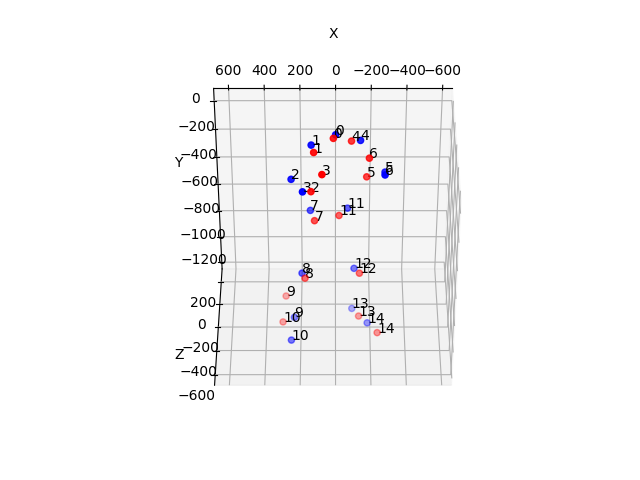

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib widget
labels=[
# 'Head',
'Neck',
'LeftArm',
'LeftForeArm',
'LeftHand',
'RightArm',
'RightForeArm',
'RightHand',
'LeftUpLeg',
'LeftLeg',
'LeftFoot',
'LeftToeBase',
'RightUpLeg',
'RightLeg',
'RightFoot',
'RightToeBase'
 ]
# test = gt_rot.T.reshape(1,15,3)
test = gt_rot.reshape(1,15,3)
# test = gt_rot_after.T.reshape(1,15,3)
# test = gt.reshape(1,15,3)
# test = mean3D.T.reshape(1,15,3)
# train = np.transpose(gt_rot,[1,0]).reshape(1,15,3)
train = pred_rescale.T.reshape(1,15,3)
# train = pred.reshape(1,15,3)
# train = gt_rescale_input
axis_azimuth = 90
axis_elev = -50



# Extracting x, y, z coordinates
# x = test[0, :, 0] - test[0, 0, 0] 
# y = test[0, :, 1] - test[0, 0, 1] 
# z = test[0, :, 2] - test[0, 0, 2] 
x = test[0, :, 0]
y = test[0, :, 1]
z = test[0, :, 2]


# x_ = train[0, :, 0] - train[0, 0, 0]
# y_ = (train[0, :, 2] - train[0, 0, 2]) *-1
# z_ = (train[0, :, 1] - train[0, 0, 1]) 

x_ = train[0, :, 0] 
y_ = train[0, :, 1]
z_ = train[0, :, 2]


# Creating a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z,color='r')
ax.scatter(x_, y_, z_,color='b')
ax.set_aspect('equal')
ax.view_init(elev=axis_elev, azim=axis_azimuth)
for i, label in enumerate(labels):
    ax.text(x[i], y[i], z[i], i)
    ax.text(x_[i], y_[i], z_[i], i)
# Labeling axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()